## Analyze A/B Test Results

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction
For this project, we will be working to understand the results of an A/B test run by an e-commerce website. Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

In [1]:
# Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(42)

%matplotlib inline

<a id='probability'></a>
### Part I - Probability

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# number of rows in the dataset
df.shape[0]

294478

In [4]:
# number of unique users in the dataset
df['user_id'].nunique()

290584

In [5]:
# proportion of users converted
conv_prop = df[df['converted'] == 1]['user_id'].nunique()/df['user_id'].nunique()
conv_prop

0.12104245244060237

In [6]:
# number of times group 'treatment' does not match landing_page 'new_page'
df[((df['group'] == 'treatment') & (df['landing_page'] != 'new_page')) | ((df['group'] != 'treatment') & (df['landing_page'] == 'new_page'))].shape[0]

3893

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

<br>

In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.

We will remove rows with incorrect entries and store the results in a new dataframe **'df2'**. 

In [8]:
df2 = df.drop(df[((df['group'] == 'treatment') & (df['landing_page'] != 'new_page')) | ((df['group'] != 'treatment') & (df['landing_page'] == 'new_page'))].index)

In [9]:
df.shape[0] - df2.shape[0]

3893

In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0

df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

<br>
Investigating the updated dataframe

In [11]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [12]:
df2.shape[0]

290585

In [13]:
# number of unique users in df2
df2['user_id'].nunique()

290584

In [14]:
df2['user_id'].duplicated().sum()

1

In [15]:
# duplicated user_id in df2
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

In [16]:
# display rows for duplicate user_id
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [17]:
# remove one of the rows with a duplicate user_id
df2.drop(1899, inplace=True)

# checking again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


<br>

#### Calculating Probability

In [18]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**`1.` What is the probability of an individual converting regardless of the page they receive?**<br>

>The probability we compute represents the overall "converted" success rate in the population, and we'll call it $p_{population}$.

In [19]:
p_conv = df2[df2['converted'] == 1].shape[0]/df2.shape[0]
p_conv

0.11959708724499628

**`2.`Given that an individual was in the `control` group, what is the probability they converted?**

In [20]:
control_df = df2.query('group == "control"')

c_conv = control_df[control_df['converted'] == 1].shape[0]/control_df.shape[0]
c_conv

0.1203863045004612

**`3.` Given that an individual was in the `treatment` group, what is the probability they converted?**

In [21]:
treatment_df = df2.query('group == "treatment"')

t_conv = treatment_df[treatment_df['converted'] == 1].shape[0]/treatment_df.shape[0]
t_conv

0.11880806551510564

>**N.B**: The probabilities we've computed in points (2) and (3) above can also be treated as conversion rates. 
We can calculate the observed difference  (`obs_diff`) between the conversion rates for the two groups.

In [22]:
# calculating observable difference
obs_diff = t_conv - c_conv
obs_diff

-0.0015782389853555567

**`4.` What is the probability that an individual received the new page?**

In [23]:
p_new = df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]
p_new

0.5000619442226688

**`5.`Consider your results from parts (1) through (4) above, explain below whether the new `treatment` group users lead to more conversions.**

>By looking exclusively at the conversion rates of both groups, it seems unlikely that the new `treatment` group users lead to more conversions. As the proportion of people in the `treatment` group  viewing the new page and converting **is less than** the proportion of people in the `control` group viewing the old page and converting.<br><br>
This can be also seen in the observable difference between the two conversion rates.

<a id='ab_test'></a>
### Part II - A/B Test

>If we want to assume that the old page is better unless the new page proves to be definitely better, at a **Type I error rate of 5%**, what should be our null and alternative hypotheses (**$H_0$** and **$H_1$**)?<br><br>
We can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

Formulating Null and Alternative Hypotheses

$$ H_0: p_{new} - p_{old} \leq 0 $$
$$ H_1: p_{new} - p_{old} > 0 $$

#### Null Hypothesis Testing:

Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

`a.` **What is the conversion rate for $p_{new}$ under the null hypothesis?**

In [24]:
p_new = df2[df2['converted'] == 1].shape[0]/df2.shape[0]
p_new

0.11959708724499628

`b.` **What is the conversion rate for $p_{old}$ under the null hypothesis?**

In [25]:
p_old = df2[df2['converted'] == 1].shape[0]/df2.shape[0]
p_old

0.11959708724499628

`c.` **What is $n_{new}$, the number of individuals in the treatment group?**

In [26]:
n_new = df2.query('group == "treatment"')['user_id'].nunique()
n_new

145310

`d.` **What is $n_{old}$, the number of individuals in the control group?**

In [27]:
n_old = df2.query('group == "control"')['user_id'].nunique()
n_old

145274

`e.` **Simulate Sample for the treatment group**<br><br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [29]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
new_page_converted.mean()

0.11924850320005506

`f.` **Simulate Sample for the control group**<br><br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [40]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
old_page_converted.mean()

0.12024175007227722

`g.` **Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above.**

In [41]:
conv_diff = new_page_converted.mean() - old_page_converted.mean()
conv_diff

-0.0009932468722221588

`h.` **Sampling distribution**<br><br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [42]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

`i.` **Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

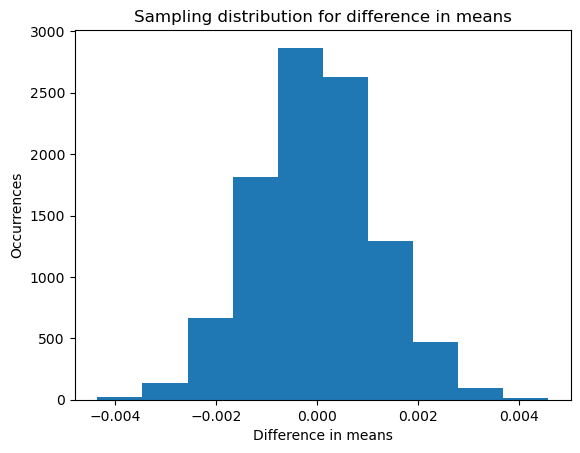

In [43]:
# p_diffs histogram
p_diffs = np.array(p_diffs)

plt.hist(p_diffs)
plt.title('Sampling distribution for difference in means')
plt.xlabel('Difference in means')
plt.ylabel('Occurrences');

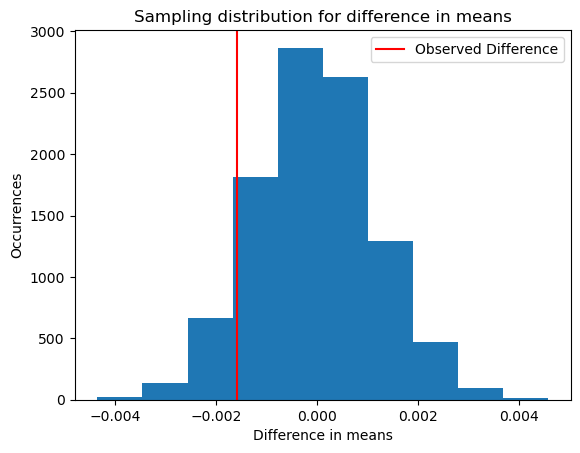

In [44]:
# histogram with actual observed difference

plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='r', label='Observed Difference')
plt.title('Sampling distribution for difference in means')
plt.xlabel('Difference in means')
plt.ylabel('Occurrences')
plt.legend();

<a id='j'></a>
`j.` **What proportion of the** p_diffs **are greater than the actual difference observed in the `df2` data?**

In [45]:
pval = (p_diffs > obs_diff).mean()
pval

0.9065

the proportion of p_diffs that are greater than the actual difference observed in df2 data is **90.65%**

`k.` **Please explain in words what you have just computed in part j above.** 
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>The value calculated in part j [above](#j) is known, in scientific studies, as the p-value. The p-value helps us determine whether our observed statistic is from the null hypothesis.<br><br>
In this case, after simulating from the null hypothesis, and plotting our observed difference against the sampling distribution, the p-value we calculated is equal to **0.9065**, which is greater than our **Type I error rate (0.05)**. This means that we fail to reject the null hypothesis, which means that based on the data we have, we do not have evidence that the new page leads to higher conversions.

`l.` **Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [46]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


In [47]:
convert_old = df2[(df2['landing_page'] == 'old_page') & (df2['converted'] == 1)].shape[0]
convert_new = df2[(df2['landing_page'] == 'new_page') & (df2['converted'] == 1)].shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

`m.` **Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.**

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---

### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [48]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

`n.` **What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts j. and k.?**<br><br>

>**Tip**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

After computing the $Z_{score}$ and p-value using the built-in function. We can see that the $Z_{score}$ is equal to **-1.3109,** and the p-value is equal to **0.905.** A negative $Z_{score}$ means our value falls below the mean, and since our $Z_{score}$ value is less than our $Z_{\alpha}$, which is 1.645 for one-tailed tests, and this is a right-tailed test, we fail to reject the null hypothesis.<br><br>

We can also observe that the p-value **(0.905)** obtained from the z-test is close to the p-value **(0.9065)** we calculated earlier, which are both still larger than our **Type I error rate (0.05),** which strengthens our claim in failing to reject the null hypothesis.

<a id='regression'></a>
### Part III - A Regression Approach


`a.` **Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?**

>Since the variable we are looking at is a binary variable, we should go with **logistic regression**

`b.` **The goal is to use statsmodels library to fit the regression model you specified in part `a.` above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:**
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [50]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


`c.` **Use** statsmodels **to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts.**

In [55]:
lm = sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


`d.` **Provide the summary of your model below, and use it as necessary to answer the following questions.**

In [56]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Nov 2022   Pseudo R-squ.:               8.077e-06
Time:                        18:53:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

<br>

`e.` **What is the p-value associated with** ab_page **? Why does it differ from the value you found in Part II**?<br><br>  

The p-value associated with the ab_page is **0.190**

These are the hypotheses from **Part II (A/B Test):**
$$ H_0: P_{new} - P_{old} \leq 0 $$
$$ H_1: P_{new} - P_{old} > 0 $$

<br>

These are the hypotheses from **Part III (Logistic Regression):**
$$ H_0: P_{new} - P_{old} \neq 0 $$
$$ H_1: P_{new} - P_{old} = 0 $$

<br>

The reason why the p-values differ in both tests is because, in Part II (A/B Test) it assumes a one-tailed test, while in Part III (Logistic Regression) it assumes a two-tailed test.

<br>

In both cases, the **p-value** is greater than our **Type I error rate (0.05)**, which means that in both tests, we fail to reject the null hypothesis as there is no evidence that suggests that the new page leads to higher conversion rates.

<br>

`f.` **Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?**

> It is a good idea to consider other factors to add into the regression model as more factors can have an influence on the conversion rates. However, adding more factors to consider in the regression model can make the model more complex and can influence the results as we may not know how an additional factor can influence our response variable.

`g.` **Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

In [61]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [68]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [79]:
# Join with the df2 dataframe
df_merged = df2.set_index('user_id').join(countries.set_index('user_id'))
df_merged.reset_index(inplace=True)
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [80]:
df_merged['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

> to answer this question we will have to look at the conversion rates for each country to assess whether the country has an impact on conversion.

In [83]:
df_merged.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1


In [91]:
# conversion rates
df_merged.groupby('country')['converted'].mean()

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

By looking at the conversion rates alone for each country, we can see that the UK has the highest conversion rate, followed by the US and Canada. So we can tell, from the conversion rates, that countries have an impact on the conversion rates

In [81]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


***In this model we will use 'UK' as our baseline.***

In [94]:
# Fit model, and summarize the results

lm = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'US']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 21 Nov 2022   Pseudo R-squ.:               2.323e-05
Time:                        20:46:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

#### Conclusions

Based on the results summary from the regression model, we can see that the p-values that pertain to conversions in Canada and the US are both greater than our **Type I error rate (0.05)**, although the p-value for the US is **0.457**, this can be explained by the relatively smaller number of users in Canada compared to the US. The negative co-efficient values mean that the conversion rates for every user that is in Canada and the US is less than the conversion rates for users in the UK, by the respective co-efficients.
<br><br>
The results obtained from the regression model can let us infer that the impact of the new page on the conversion rates in different countries is insignificant. Ultimately, the combined results of both the A/B test and Regression model provide no evidence that the new page leads to higher conversion rates, regardless of country. Thus, we fail to reject the null hypothesis.
<br><br>
Since we have a large enough sample size, we can ensure that running the test for longer would not change the results, and the best move to make is to change the new landing page.